# Бонусное домашнее задание

## Part 0

В данном домашнем задании вам предстоит реализовать СLIP -- self-supervision модель которая выучивает зависимости между картинками и текстов в едином векторном пространстве. Для выполнения этого домашнего задания вам понадобится GPU и несколько дополнительных библиотек. Автор рекомендует делать все исключительно в Kaggle. 


[Ссылка на датасет](https://www.kaggle.com/datasets/keenwarrior/small-flicker-data-for-image-captioning)

[Ссылка на статью](https://openai.com/research/clip)

Задания в ноутбуке будут во многом опираться на статью, поэтому рекомендуется ее прочитать перед выполнением.

In [1]:
!pip install timm
!pip install transformers

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
import timm
PATH_TO_IMAGES = '/kaggle/input/small-flicker-data-for-image-captioning/flickr1k/images'

In [3]:
!git clone https://github.com/xiyori/intro-to-dl-hse.git

Cloning into 'intro-to-dl-hse'...
remote: Enumerating objects: 1240, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 1240 (delta 234), reused 190 (delta 190), pack-reused 961 (from 4)
Receiving objects: 100% (1240/1240), 370.22 MiB | 45.03 MiB/s, done.
Resolving deltas: 100% (479/479), done.
Updating files: 100% (103/103), done.


## Part 1 (8 баллов)

Для начала нам нужно реализовать составляющие модели: Кодировщик картинок, текста и проектор на какое-то маломерное пространство. В папке с заданием есть соответствующие файлы, заполните пропуски в них опираясь на docstring-и.

Разбалловка следующая: 

Правильно реализованные кодировщики: 2 балла.

Правильно реализованный проектор: 2 балла.

Правильно реализованный класс СLIP: 4 балла.

In [4]:
!touch /kaggle/working/CLIPDataset.py

In [5]:
# %%writefile /kaggle/working/intro-to-dl-hse/homeworks-small/shw-04-ssl-bonus/CLIPDataset.py
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
to_tensor = T.ToTensor()
import typing as tp
import os

class CLIPDataset(Dataset):
    def __init__(self, image_path, image_filenames, captions, tokenizer):
        """
        :image_path -- path to images
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        :tokenizer -- LM Tokenizer 
        """
        self.max_tokenizer_length = 200
        self.truncation = True
        self.padding = True
        self.image_path = image_path
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.tokenizer = tokenizer
        self.encoded_captions = self.tokenizer(self.captions, padding=self.padding, 
                                               max_length=self.max_tokenizer_length, truncation=self.truncation)
        self.transforms = T.Compose([
                          T.Resize([224, 244]), 
                          to_tensor,
                          T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def __getitem__(self, idx: int) -> tp.Dict[str, tp.Union[torch.Tensor, str]]:

        """
        This one should return dict(keys=['image', 'caption'], value=[Image, Caption])
        """
        item = {
            key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()
        }
        item['image'] = self.transforms(Image.open(os.path.join(self.image_path, self.image_filenames[idx])))
        item['caption'] = self.captions[idx]
        return item


    def __len__(self):
        return len(self.captions)

In [6]:
!touch /kaggle/working/ImageEncoder.py

In [7]:
# %%writefile /kaggle/working/ImageEncoder.py
import torch.nn as nn
import timm 

class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector.
    """
    def __init__(
        self, model_name="resnet50", pretrained=True, trainable=False
        ):
        """
        We will use standard pretrained ResNet50, and set freeze its parameters.
        Look the documentation of TIMM on how to donwload the model: https://timm.fast.ai/
        """
        super().__init__()
        
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool="avg")
        
        if not trainable:
            for param in self.model.parameters():
                param.requires_grad = True


    def forward(self, x):
        return self.model(x)

In [8]:
!touch /kaggle/working/ProjectionHead.py

In [9]:
# %%writefile /kaggle/working/intro-to-dl-hse/homeworks-small/shw-04-ssl-bonus/ProjectionHead.py
import torch.nn as nn

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=256,
        dropout=0.1
    ):
        super().__init__()

        """
        Here you should write simple 2-layer MLP consisting:
        2 Linear layers, GELU activation, Dropout and LayerNorm. 
        Do not forget to send a skip-connection right after projection and before LayerNorm.
        The whole structure should be in the following order:
        [Linear, GELU, Linear, Dropout, Skip, LayerNorm]
        """
        self.projection_1 = nn.Linear(embedding_dim, projection_dim)
        self.projection_2 = nn.Sequential(
            nn.GELU(),
            nn.Linear(projection_dim, projection_dim),
            nn.Dropout(dropout)
        )
        self.lnorm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):

        state_1 = self.projection_1(x)
        state_2 = self.projection_2(state_1)

        output = state_2 + state_1

        return self.lnorm(output)

In [10]:
!touch /kaggle/working/TextEncoder.py

In [11]:
# %%writefile /kaggle/working/TextEncoder.py
from transformers import DistilBertModel, DistilBertConfig
import torch

class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=False):
        super().__init__()
        """
        Create the model and set its weights frozen. 
        Use Transformers library docs to find out how to do this.
        """
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())


        if not trainable:
            for param in self.model.parameters():
                param.requires_grad = False

        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        """
        Pass the arguments through the model and make sure to return CLS token embedding
        """
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

        return outputs[:, self.target_token_idx, :]

In [12]:
# from .CLIPDataset import CLIPDataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
# from .ImageEncoder import ImageEncoder
# from .ProjectionHead import ProjectionHead
# from .TextEncoder import TextEncoder

In [13]:
import math
import torch.nn.functional as F


class CLIP(nn.Module):
    def __init__(self, image_embedding=2048, text_embedding=768, temp =1):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projections = ProjectionHead(image_embedding)
        self.text_projections = ProjectionHead(text_embedding)
        # self.temp = nn.Parameter(torch.tensor(temp))
        self.temp = temp
    def forward(self, batch):
        """
        :batch: dict of images and text
        Here is what you should do:
        1) extract image and text features from batch
        2) project features into projection space (small latent space)
        3) compute cosine similarity with temperature this will be your logits
        4) compute "true" logits (eg. cosine similarity between images and images, text and text)
        5) create targets by averaging similarities from step above (do not forget about temperature)
        6) compute mean loss (see paper)
        7) return loss

        Overall: read paper.
        
        """

        images, captions = self.image_encoder(batch['image']), self.text_encoder(batch['input_ids'], attention_mask=batch['attention_mask'])
        images_proj, captions_proj = self.image_projections(images), self.text_projections(captions)

        logits = (images_proj @ captions_proj.T) / self.temp

        img_sim, txt_sim =  (images_proj @ images_proj.T), (captions_proj @ captions_proj.T)

        targets = F.softmax((img_sim + txt_sim) / 2 * self.temp, dim=-1)

        CE_img, CE_txt = CE(logits, targets), CE(logits.T, targets.T)

        return ((CE_img + CE_txt) / 2).mean()

    

def CE(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss   

# Part 2. (0 Баллов)

Здесь вам нужно вписать правильный путь до csv файла на своей машине и запустить код.

In [14]:
def make_train_valid_dfs():
    dataframe = pd.read_csv('/kaggle/input/small-flicker-data-for-image-captioning/flickr1k/captions.csv')
    dataframe["id"] = np.array(list(dataframe.index))
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [15]:
def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        '/kaggle/input/small-flicker-data-for-image-captioning/flickr1k/images',
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer
    )
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        num_workers=1,
        shuffle=True if mode == "train" else False,
    )
    return dataloader, dataset

In [16]:
class AvgMeter:
    def __init__(self, name="CrossEntropyLoss"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    def __format__(self, formatspec):
        text = f"{self.name}: {format(self.avg, formatspec)}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [17]:
def train(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

@torch.no_grad()
def validate(model, validation_loader):
    loss_meter = AvgMeter()
    for batch in tqdm(validation_loader, desc="Validating", total=len(validation_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

## Part 3. (2 балла)

За вас написан минимальный код для обучения, если он запускается и модель учится, то за этот пункт вы получите 0.5 балла. Чтобы получить полный балл за задание вам нужно будет провести несколько экспериментов и поподбирать гиперпараметры. Можно начать со статьи.

In [18]:
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10
def procedure():
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
    model = CLIP().to(device)
    params = [{"params": model.image_encoder.parameters()}, 
              {"params" : model.text_encoder.parameters()},
              {"params" : itertools.chain(model.image_projections.parameters(),
                                          model.text_projections.parameters())}]
    optimizer = torch.optim.Adam(params)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1, factor=0.8)
    # lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25, eta_min=1e-7)
    step="epoch"
    for epoch in range(EPOCH):
        print(f"Epoch: {epoch}. Train and Validation in progress...")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        val_loss = validate(model, val_loader)
        
        lr_scheduler.step(val_loss.avg)
        print(f"Epoch: {epoch},", end="\n")
        print(f"Train loss: {train_loss:0.3f}", end="\n")
        print(f"Validation loss: {val_loss:0.3f}")
    return model

### 1. Сетап из статьи
* ### **epoch:** 20 (в оригинале 35)
* ### **temp:** 1 + сделал этот параметр обучаемым
* ### **projection_dim:** 256
* ### **dropout:** 0.2
* ### **scheduler:** CosineAnnealingLR

In [19]:
model = procedure()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0,
Train loss: CrossEntropyLoss: 6.521
Validation loss: CrossEntropyLoss: 3.579
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1,
Train loss: CrossEntropyLoss: 3.306
Validation loss: CrossEntropyLoss: 3.065
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2,
Train loss: CrossEntropyLoss: 2.753
Validation loss: CrossEntropyLoss: 2.493
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4,
Train loss: CrossEntropyLoss: 1.629
Validation loss: CrossEntropyLoss: 1.671
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5,
Train loss: CrossEntropyLoss: 1.184
Validation loss: CrossEntropyLoss: 1.592
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6,
Train loss: CrossEntropyLoss: 0.923
Validation loss: CrossEntropyLoss: 1.522
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7,
Train loss: CrossEntropyLoss: 0.738
Validation loss: CrossEntropyLoss: 1.526
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8,
Train loss: CrossEntropyLoss: 0.636
Validation loss: CrossEntropyLoss: 1.543
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9,
Train loss: CrossEntropyLoss: 0.559
Validation loss: CrossEntropyLoss: 1.554
Epoch: 10. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10,
Train loss: CrossEntropyLoss: 0.499
Validation loss: CrossEntropyLoss: 1.520
Epoch: 11. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11,
Train loss: CrossEntropyLoss: 0.454
Validation loss: CrossEntropyLoss: 1.485
Epoch: 12. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12,
Train loss: CrossEntropyLoss: 0.390
Validation loss: CrossEntropyLoss: 1.479
Epoch: 13. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13,
Train loss: CrossEntropyLoss: 0.361
Validation loss: CrossEntropyLoss: 1.485
Epoch: 14. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14,
Train loss: CrossEntropyLoss: 0.370
Validation loss: CrossEntropyLoss: 1.406
Epoch: 15. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15,
Train loss: CrossEntropyLoss: 0.304
Validation loss: CrossEntropyLoss: 1.506
Epoch: 16. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 16,
Train loss: CrossEntropyLoss: 0.305
Validation loss: CrossEntropyLoss: 1.474
Epoch: 17. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 17,
Train loss: CrossEntropyLoss: 0.312
Validation loss: CrossEntropyLoss: 1.508
Epoch: 18. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 18,
Train loss: CrossEntropyLoss: 0.261
Validation loss: CrossEntropyLoss: 1.556
Epoch: 19. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 19,
Train loss: CrossEntropyLoss: 0.272
Validation loss: CrossEntropyLoss: 1.523


 ### 2. Бейзлайн


In [19]:
model = procedure()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0,
Train loss: CrossEntropyLoss: 5.504
Validation loss: CrossEntropyLoss: 3.607
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1,
Train loss: CrossEntropyLoss: 3.230
Validation loss: CrossEntropyLoss: 3.097
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2,
Train loss: CrossEntropyLoss: 2.728
Validation loss: CrossEntropyLoss: 2.590
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3,
Train loss: CrossEntropyLoss: 2.152
Validation loss: CrossEntropyLoss: 2.120
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4,
Train loss: CrossEntropyLoss: 1.570
Validation loss: CrossEntropyLoss: 1.706
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5,
Train loss: CrossEntropyLoss: 1.171
Validation loss: CrossEntropyLoss: 1.602
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6,
Train loss: CrossEntropyLoss: 0.928
Validation loss: CrossEntropyLoss: 1.662
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7,
Train loss: CrossEntropyLoss: 0.752
Validation loss: CrossEntropyLoss: 1.489
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8,
Train loss: CrossEntropyLoss: 0.608
Validation loss: CrossEntropyLoss: 1.487
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9,
Train loss: CrossEntropyLoss: 0.587
Validation loss: CrossEntropyLoss: 1.436


In [44]:
model = procedure()

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0,
Train loss: CrossEntropyLoss: 18.979
Validation loss: CrossEntropyLoss: 6.168
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1,
Train loss: CrossEntropyLoss: 8.460
Validation loss: CrossEntropyLoss: 4.777
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2,
Train loss: CrossEntropyLoss: 5.586
Validation loss: CrossEntropyLoss: 4.081
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3,
Train loss: CrossEntropyLoss: 4.405
Validation loss: CrossEntropyLoss: 3.636
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4,
Train loss: CrossEntropyLoss: 3.736
Validation loss: CrossEntropyLoss: 3.490
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5,
Train loss: CrossEntropyLoss: 3.476
Validation loss: CrossEntropyLoss: 3.382
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6,
Train loss: CrossEntropyLoss: 3.312
Validation loss: CrossEntropyLoss: 3.347
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7,
Train loss: CrossEntropyLoss: 3.108
Validation loss: CrossEntropyLoss: 3.220
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8,
Train loss: CrossEntropyLoss: 2.990
Validation loss: CrossEntropyLoss: 3.182
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9,
Train loss: CrossEntropyLoss: 2.810
Validation loss: CrossEntropyLoss: 2.967
Epoch: 10. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 10,
Train loss: CrossEntropyLoss: 2.685
Validation loss: CrossEntropyLoss: 2.870
Epoch: 11. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 11,
Train loss: CrossEntropyLoss: 2.441
Validation loss: CrossEntropyLoss: 2.782
Epoch: 12. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 12,
Train loss: CrossEntropyLoss: 2.314
Validation loss: CrossEntropyLoss: 2.715
Epoch: 13. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 13,
Train loss: CrossEntropyLoss: 2.265
Validation loss: CrossEntropyLoss: 2.846
Epoch: 14. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 14,
Train loss: CrossEntropyLoss: 2.156
Validation loss: CrossEntropyLoss: 2.623
Epoch: 15. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 15,
Train loss: CrossEntropyLoss: 2.129
Validation loss: CrossEntropyLoss: 2.513
Epoch: 16. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 16,
Train loss: CrossEntropyLoss: 2.075
Validation loss: CrossEntropyLoss: 2.506
Epoch: 17. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 17,
Train loss: CrossEntropyLoss: 2.082
Validation loss: CrossEntropyLoss: 2.351
Epoch: 18. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 18,
Train loss: CrossEntropyLoss: 2.058
Validation loss: CrossEntropyLoss: 2.417
Epoch: 19. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 19,
Train loss: CrossEntropyLoss: 1.999
Validation loss: CrossEntropyLoss: 2.413
Epoch: 20. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 20,
Train loss: CrossEntropyLoss: 1.977
Validation loss: CrossEntropyLoss: 2.317
Epoch: 21. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 21,
Train loss: CrossEntropyLoss: 1.999
Validation loss: CrossEntropyLoss: 3.309
Epoch: 22. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 22,
Train loss: CrossEntropyLoss: 1.899
Validation loss: CrossEntropyLoss: 2.221
Epoch: 23. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 23,
Train loss: CrossEntropyLoss: 1.876
Validation loss: CrossEntropyLoss: 2.467
Epoch: 24. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

Validating:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 24,
Train loss: CrossEntropyLoss: 1.895
Validation loss: CrossEntropyLoss: 3.274


## Part 4 (0 баллов)

Просто посмотрим на результаты.

In [20]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        # image_features = model.image_encoder(batch["image"].permute(0, 3, 1, 2)).to(device)
        image_features = model.image_encoder(batch["image"]).to(device)
        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

In [21]:
import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGES}" + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()
    

In [22]:
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
data = pd.read_csv('/kaggle/input/small-flicker-data-for-image-captioning/flickr1k/captions.csv')

In [58]:
from collections import defaultdict

freq = defaultdict(int)

for i in range(data.shape[0]):
    line = data['caption'].get(i).split()
    for j in line:
        freq[j] += 1

freq = pd.DataFrame([freq.keys(), freq.values()]).T.rename(columns={0: 'word', 1:'freq'})

In [59]:
freq[freq['freq'] > 20].sort_values('freq', ascending=False)

,word,freq
3,a,5214
15,.,4516
0,A,2898
2,in,2299
23,the,1859
...,...,...
1334,motorcycle,21
1528,hiking,21
610,toddler,21
158,stone,21


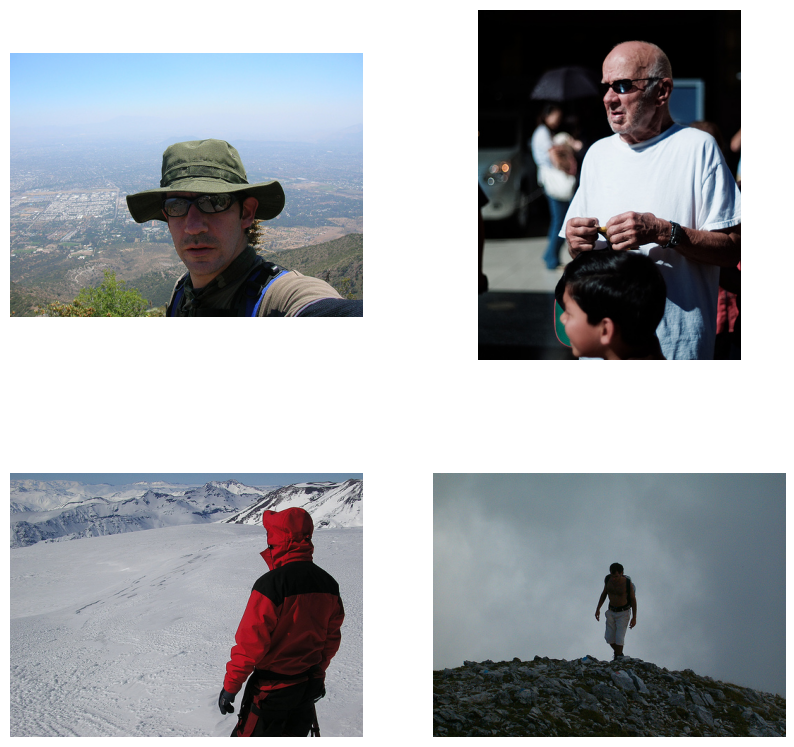

In [25]:
find_match(model, image_embeddings, "man", valid_df["image"].values)

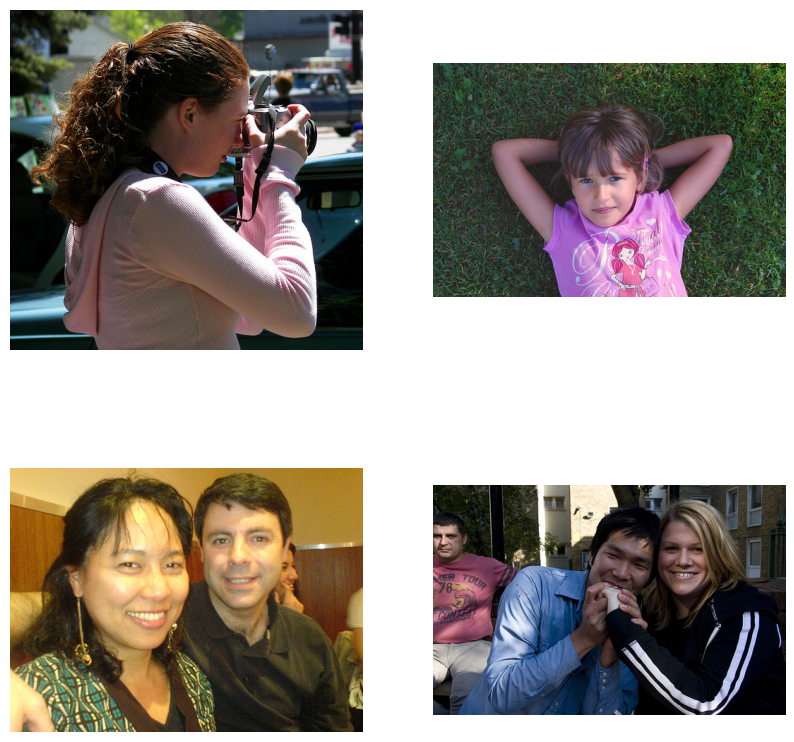

In [26]:
find_match(model, image_embeddings, "girl", valid_df["image"].values)

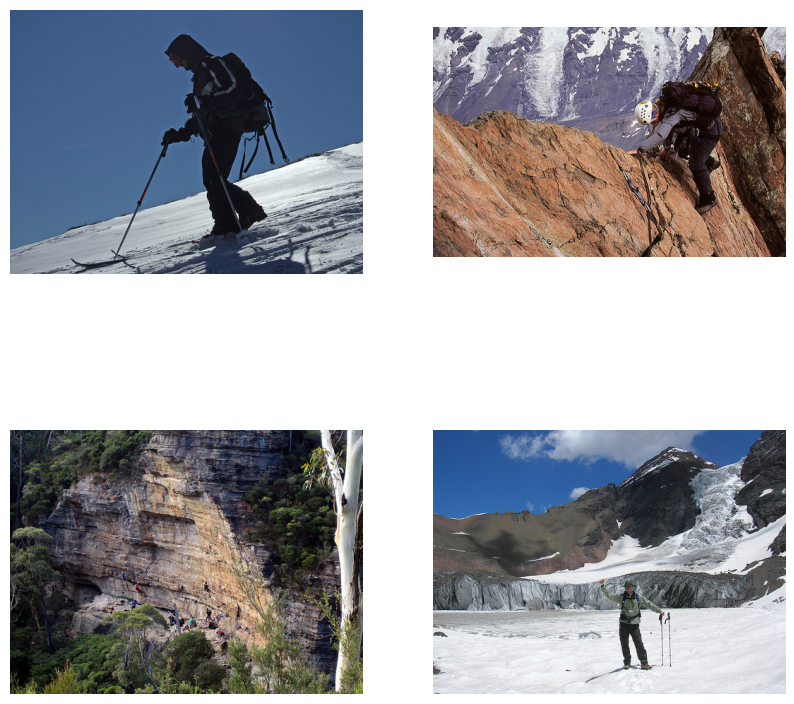

In [56]:
find_match(model, image_embeddings, "hiking", valid_df["image"].values)

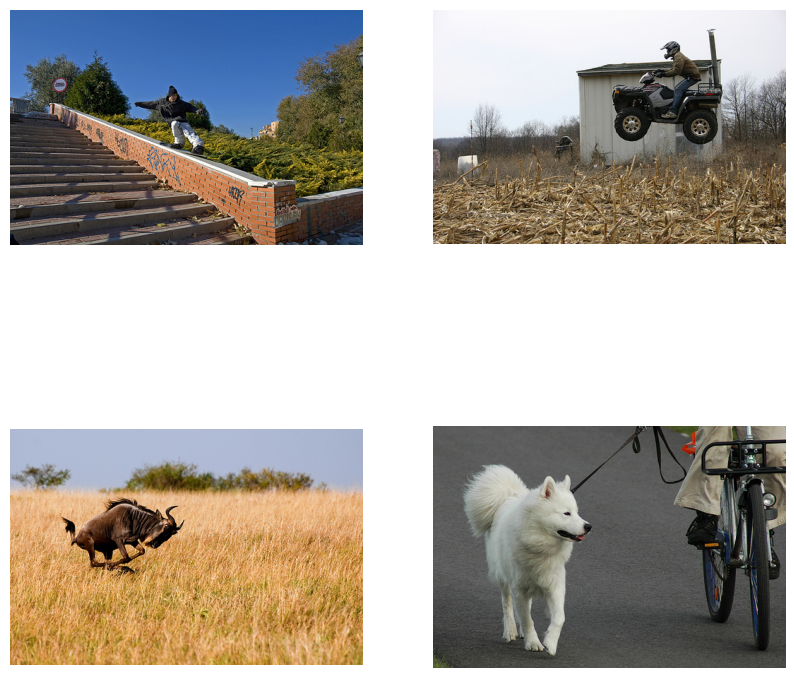

In [57]:
find_match(model, image_embeddings, "motorcycle", valid_df["image"].values)

## Опишите свои результаты.

> ## Выводы:
> #### По результатам видно, что модель хорошо находит изображения по достаточно популярному запросу (например, man или girl), что очевидно, поскольку таких объектов было достаточно много в обучающей выборке. Что касается редких объектов (в количестве 20 штук), то тут на примерах motorcycle и hiking нету однозначного ответа касаемо качества модели. Так, например, по запросу motorcycle получились достаточно плохие примеры, потому что среди них присутствуют изображения, которые точно не относятся к мотоциклам. Касаемо hiking, то тут получились результаты получше и видно, что на все изображения на тематику пешего туризма